In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv('emails.csv')
data.head()


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
data.shape


(5728, 2)

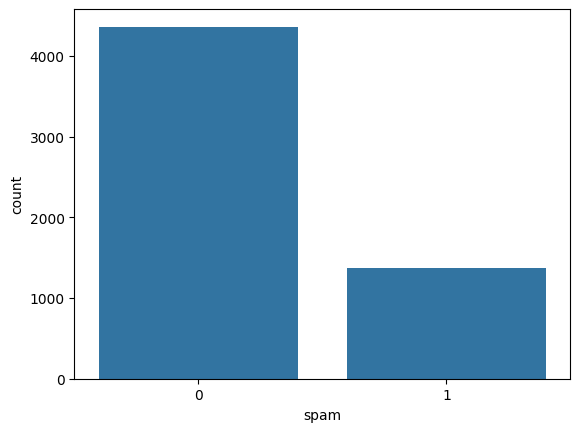

In [4]:
sns.countplot(x='spam', data=data)
plt.show()


Text(0.5, 0, 'Message types')

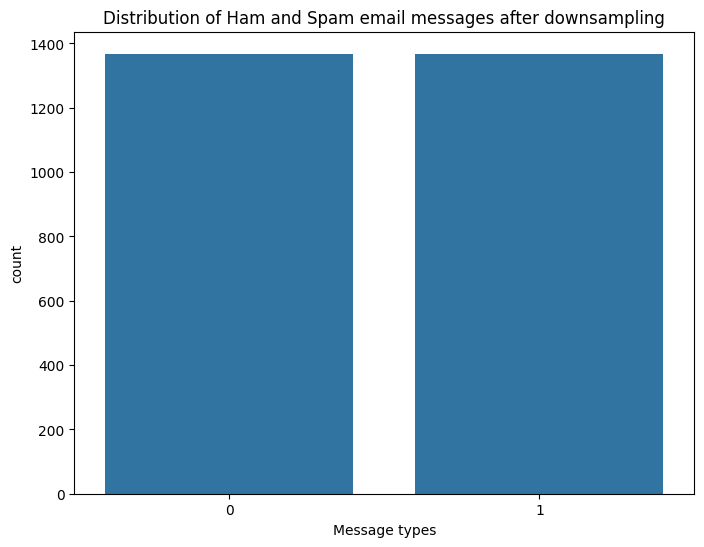

In [10]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
						random_state=42)

# Plotting the counts of down sampled dataset
# Use pd.concat instead of append
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [11]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [12]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [13]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


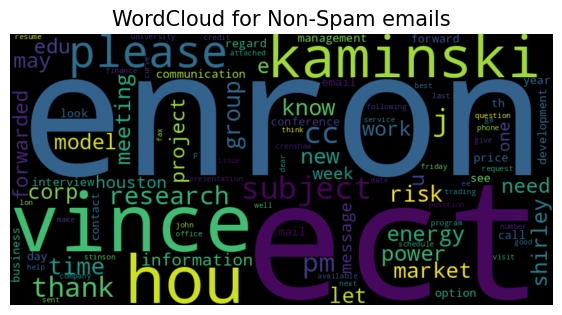

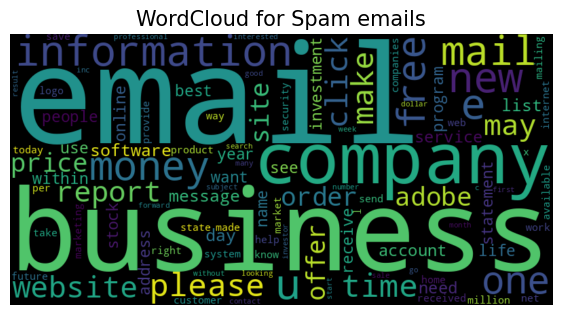

In [14]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


In [15]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


In [16]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


In [17]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [19]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [23]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9743 - loss: 0.1403 - val_accuracy: 0.9672 - val_loss: 0.1513 - learning_rate: 5.0000e-04
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9794 - loss: 0.1059 - val_accuracy: 0.9763 - val_loss: 0.1096 - learning_rate: 5.0000e-04
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9853 - loss: 0.0779 - val_accuracy: 0.9708 - val_loss: 0.1291 - learning_rate: 5.0000e-04
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9876 - loss: 0.0672 - val_accuracy: 0.9726 - val_loss: 0.1236 - learning_rate: 5.0000e-04
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9884 - loss: 0.0631 - val_accuracy: 0.9763 - val_loss: 0.1101 - learning_rate: 2.5000e-04


In [21]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9680 - loss: 0.1759
Test Loss : 0.19075559079647064
Test Accuracy : 0.9653284549713135


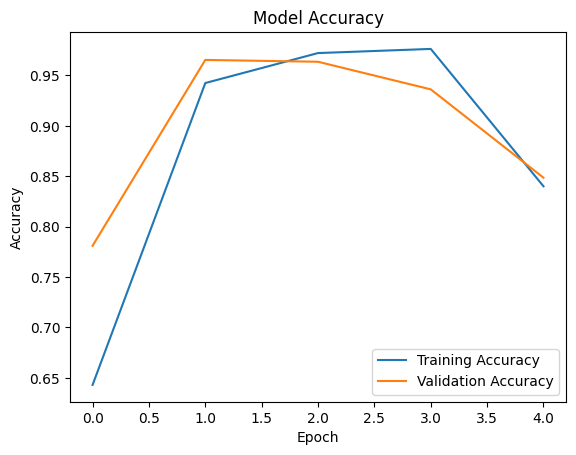

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
